# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
%matplotlib inline
from pandas.tseries.offsets import MonthEnd
from matplotlib.pylab import rcParams
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = (15, 6)
import pmdarima as pm
print('done')

done


# Variables to Set

In [2]:
data = 'NORMAL_DLY_sample_csv.csv'
target_column = 'DLY-TMAX-NORMAL'
pred_date = '2021-04-13'

# Load/Transform Data

In [16]:
df = pd.read_csv(data)
df.columns = df.columns.str.replace('DATE', 'Date')
df['Date'] = pd.to_datetime(df['Date'],format="%Y%m%d")
df.index = df['Date']
df = df.drop('Date',axis=1)
df

,DLY-TMAX-NORMAL,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DLY-TMIN-NORMAL,MTD-PRCP-NORMAL
Date,,,,,,,,
2010-01-01,145,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-33,2
2010-01-02,144,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-35,4
2010-01-03,143,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-36,5
2010-01-04,142,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-38,7
2010-01-05,141,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-39,9
...,...,...,...,...,...,...,...,...
2010-12-27,154,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-23,64
2010-12-28,152,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-25,67
2010-12-29,150,GHCND:USC00327027,PETERSBURG 2 N ND US,466.3,48.0355,-98.01,-27,69


# Profile Data

In [11]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Split into Training and Validation Data

<Axes: xlabel='Date'>

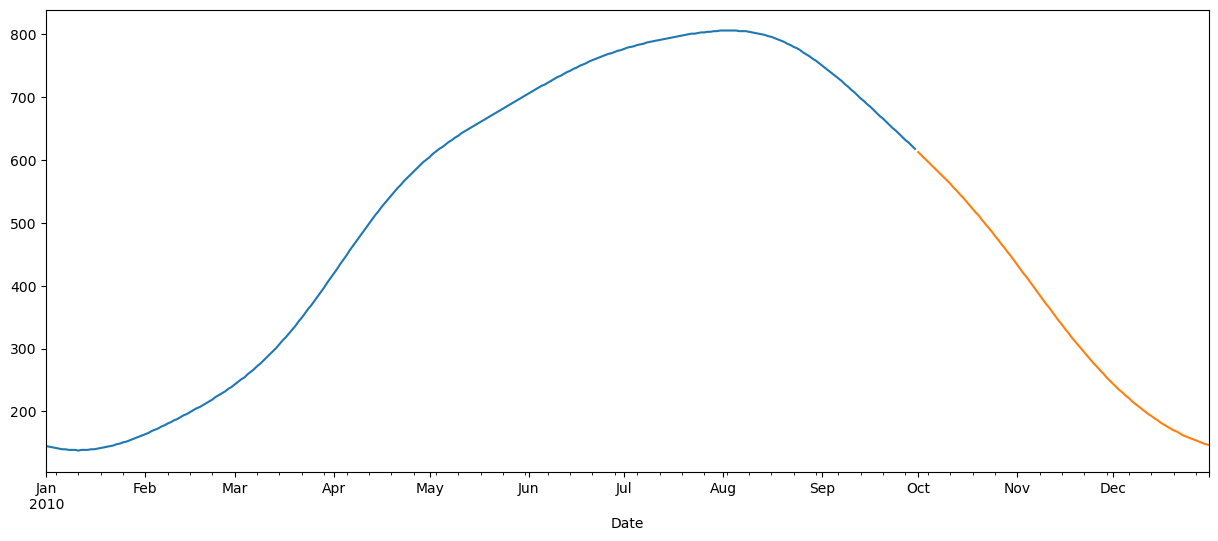

In [17]:
train = df[:int(0.75*(len(df)))]
valid = df[int(0.75*(len(df))):]
valid

#plotting the data
ax = train[target_column].plot()
valid[target_column].plot(ax=ax)

# Stationarity
- Stationarity means that the statistical properties of the process do not change over time
- Random variables of the stochastic process remains the same as we shift it along the time index axis. (Mean and Variance)
- Stationary processes are easier to analyze

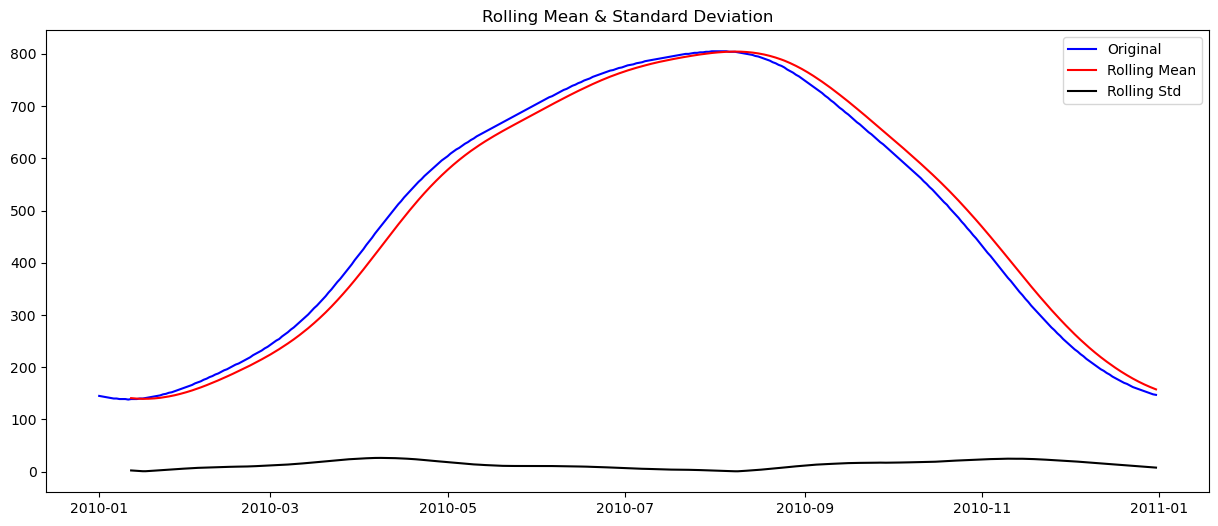

In [18]:
from statsmodels.tsa.stattools import adfuller as adf
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(df[target_column])

#### Analysis of Stationarity
- Even though there is an increasing trend for GDP, the rolling mean and standard deviations do not have large variances from year to year.

# Trends and Seasonality
 - Plot of Original Data
 - Plot of Smoothed Moving Average of Original Data
 - Plot of Seasonality
     - Seasonality is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly
 - Plot of Residuals on a Simple Regression Fit
     - What is left over after fitting a model.

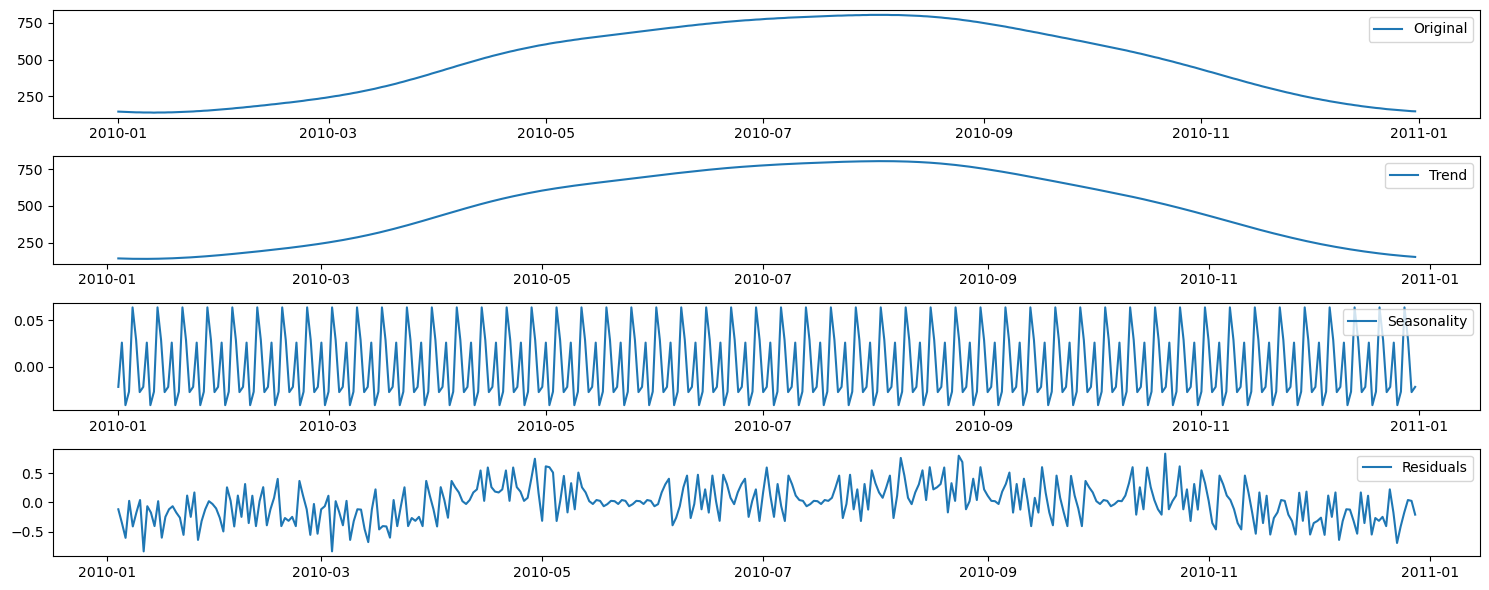

In [19]:
#estimating trend and seasonlity
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df[target_column])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df[target_column], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ARIMA Modeling without Regressors (Only the Target)
- Autoregressive (AR) integrated (I) moving average (MA) models
- We are not going to go into a lot of detail on the parts of ARIMA, Differencing and Lags (This could be multiple college semester courses)
- Instead, what we will do is use Auto-Arima package to find the best model.

In [20]:
best_noregressors = pm.auto_arima(train.iloc[:,0], 
                   trace=True, error_action='ignore', suppress_warnings=True,
                   seasonal=True,
                   m=12, #12 Months
                   stepwise=False,
                   D=None, 
                   max_D=10,
                   start_p=5, start_q=0, 
                   start_P=5, start_Q=0,
                   max_p=5, max_q=5, max_P=5, max_Q=5,
                   information_criterion='aic', #‘aic’, ‘bic’, ‘hqic’, ‘oob’
                   n_jobs = -1,
                  )

print(best_noregressors)
print('Order :',best_noregressors.order)
print('Seasonal Order :',best_noregressors.seasonal_order)
print('Intercept :',best_noregressors.with_intercept)
print(best_noregressors.summary())


Best model:  ARIMA(3,2,2)(0,0,0)[12]          
Total fit time: 19.473 seconds
 ARIMA(3,2,2)(0,0,0)[12]          
Order : (3, 2, 2)
Seasonal Order : (0, 0, 0, 12)
Intercept : False
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -131.160
Date:                Tue, 12 Dec 2023   AIC                            274.319
Time:                        16:05:25   BIC                            295.932
Sample:                    01-01-2010   HQIC                           282.997
                         - 09-30-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4421      0.

# Fit Model and Make Predictions on Validation

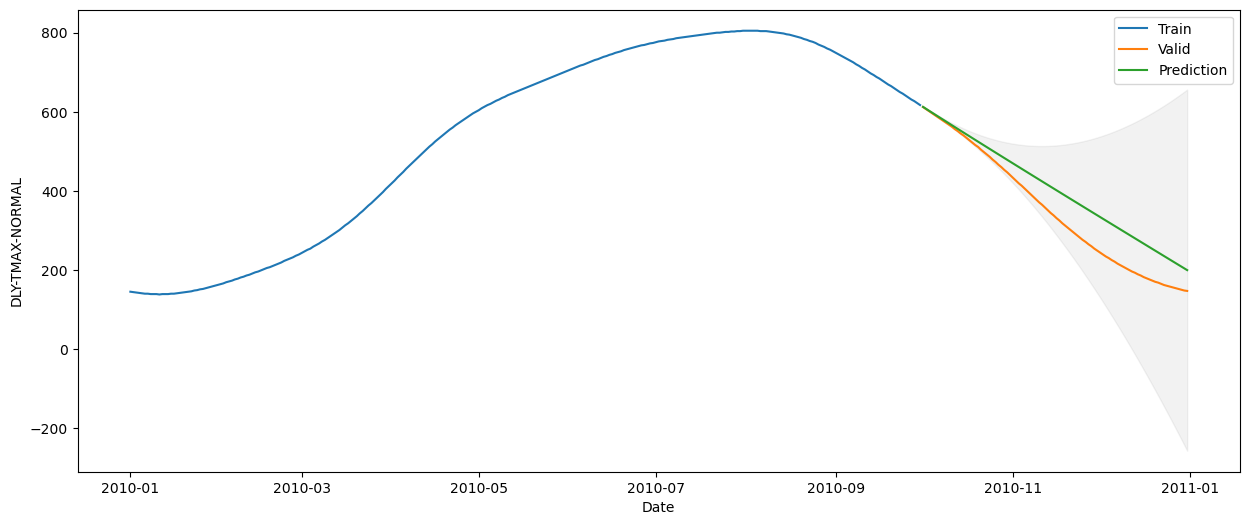

In [21]:
best_noregressors.fit(train.iloc[:,0])
best_noregressors_forecast = best_noregressors.predict(n_periods=len(valid), exogenous=True, return_conf_int=True,  alpha=0.05)

preds_best_noregressors = pd.merge(pd.DataFrame(best_noregressors_forecast[0],
                 index = pd.to_datetime(valid.index),
                 columns=['Prediction']),pd.DataFrame(best_noregressors_forecast[1][:,0],
                        index = pd.to_datetime(valid.index),
                        columns=['Lower']),how='left', left_index=True,right_index=True)

preds_best_noregressors = pd.merge(preds_best_noregressors,pd.DataFrame(best_noregressors_forecast[1][:,1],
                        index = pd.to_datetime(valid.index),
                        columns=['Upper']),how='left',left_index=True,right_index=True)

#plot the predictions for validation set
plt.plot(train.iloc[:,0], label='Train')
plt.plot(valid.iloc[:,0], label='Valid')
plt.plot(preds_best_noregressors.Prediction, label='Prediction')

plt.fill_between(preds_best_noregressors.index,preds_best_noregressors.Lower,preds_best_noregressors.Upper,color='k', alpha=.05)
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend(loc='best')
plt.show()

In [22]:
preds_best_noregressors

,Prediction,Lower,Upper
Date,,,
2010-10-01,612.539495,611.777505,613.301484
2010-10-02,607.803066,606.899434,608.706699
2010-10-03,603.089184,601.981124,604.197243
2010-10-04,598.443673,597.018355,599.868991
2010-10-05,593.766753,591.992371,595.541136
...,...,...,...
2010-12-27,217.439430,-200.237737,635.116598
2010-12-28,212.972825,-214.311568,640.257218
2010-12-29,208.506905,-228.481316,645.495125


# ARIMA Modeling with Regressors (Target and Additional Features)
- exogenous parameter is the ony change

In [23]:
best_regressors = pm.auto_arima(train.iloc[:,0], 
                   trace=True, error_action='ignore', suppress_warnings=True,
                   seasonal=True,
                   m=12, #12 Months
                   stepwise=False,
                   D=None, 
                   max_D=10,
                   start_p=0, start_q=0, 
                   start_P=0, start_Q=0,
                   max_p=5, max_q=5, max_P=5, max_Q=5,
                   information_criterion='aic', #‘aic’, ‘bic’, ‘hqic’, ‘oob’
                   n_jobs = -1,
                   exogenous=train.iloc[:,1:]
                  )

print(best_regressors)
print('Order :',best_regressors.order)
print('Seasonal Order :',best_regressors.seasonal_order)
print('Intercept :',best_regressors.with_intercept)
print(best_regressors.summary())


Best model:  ARIMA(3,2,2)(0,0,0)[12]          
Total fit time: 16.961 seconds
 ARIMA(3,2,2)(0,0,0)[12]          
Order : (3, 2, 2)
Seasonal Order : (0, 0, 0, 12)
Intercept : False
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -131.160
Date:                Tue, 12 Dec 2023   AIC                            274.319
Time:                        16:06:56   BIC                            295.932
Sample:                    01-01-2010   HQIC                           282.997
                         - 09-30-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4421      0.

# Fit Model and Make Predictions on Validation

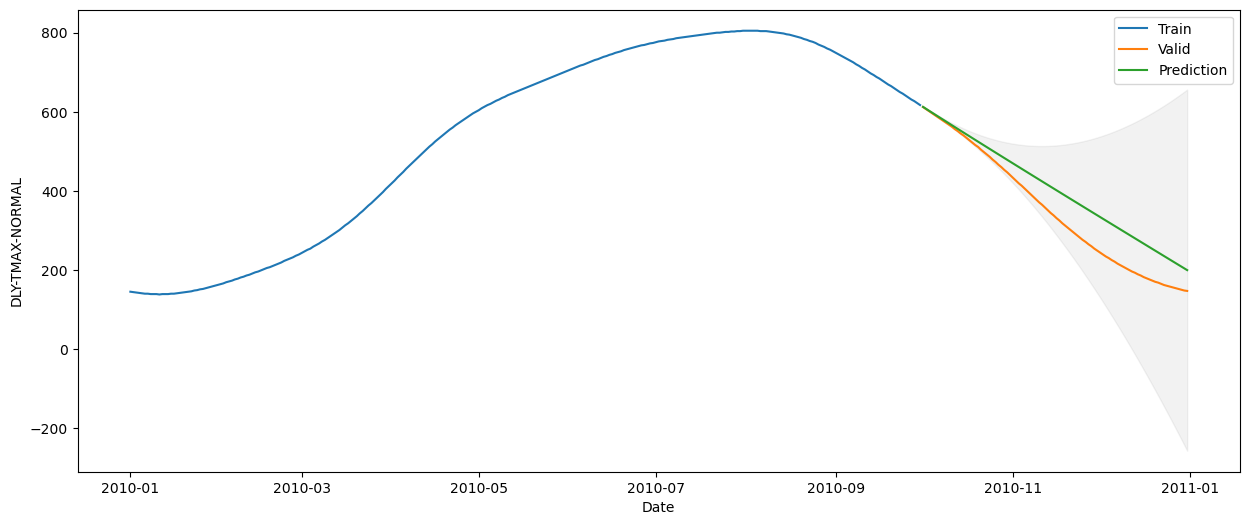

In [24]:
best_regressors.fit(train.iloc[:,0])
best_regressors_forecast = best_regressors.predict(n_periods=len(valid), exogenous=True, return_conf_int=True,  alpha=0.05)

preds_best_regressors = pd.merge(pd.DataFrame(best_regressors_forecast[0],
                 index = pd.to_datetime(valid.index),
                 columns=['Prediction']),pd.DataFrame(best_regressors_forecast[1][:,0],
                        index = pd.to_datetime(valid.index),
                        columns=['Lower']),how='left', left_index=True,right_index=True)

preds_best_regressors = pd.merge(preds_best_regressors,pd.DataFrame(best_regressors_forecast[1][:,1],
                        index = pd.to_datetime(valid.index),
                        columns=['Upper']),how='left',left_index=True,right_index=True)

#plot the predictions for validation set
plt.plot(train.iloc[:,0], label='Train')
plt.plot(valid.iloc[:,0], label='Valid')
plt.plot(preds_best_regressors.Prediction, label='Prediction')

plt.fill_between(preds_best_regressors.index,preds_best_regressors.Lower,preds_best_regressors.Upper,color='k', alpha=.05)
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend(loc='best')
plt.show()

# Choose a ARIMA model and predict future

In [25]:
pred_months = 12
model = best_regressors.fit(df.iloc[:,0])



forecast = model.predict(n_periods=pred_months, exogenous=True, return_conf_int=True,  alpha=0.05)
forecast

(2011-01-01    145.342328
 2011-01-02    144.033265
 2011-01-03    142.838634
 2011-01-04    141.704542
 2011-01-05    140.694713
 2011-01-06    139.782905
 2011-01-07    138.968735
 2011-01-08    138.253916
 2011-01-09    137.634791
 2011-01-10    137.110121
 2011-01-11    136.678396
 2011-01-12    136.337881
 Freq: D, dtype: float64,
 array([[144.57123387, 146.1134212 ],
        [143.11100881, 144.95552107],
        [141.68432946, 143.992938  ],
        [140.25070179, 143.15838279],
        [138.90001008, 142.48941515],
        [137.57495053, 141.99085887],
        [136.27431515, 141.66315536],
        [134.9956231 , 141.51220924],
        [133.72950577, 141.5400759 ],
        [132.47151022, 141.74873222],
        [131.21679107, 142.14000026],
        [129.96059507, 142.71516762]]))

In [26]:
preds = pd.merge(pd.DataFrame(forecast[0],columns=['Prediction']).reset_index(),
                 pd.DataFrame(forecast[1][:,0],columns=['Lower']),
                              how='left', left_index=True,right_index=True)
preds = pd.merge(preds,pd.DataFrame(forecast[1][:,1],columns=['Upper']),
                              how='left', left_index=True,right_index=True)

preds = preds.rename(columns={'index':'Date'})

preds = preds.set_index('Date')

display(preds)

,Prediction,Lower,Upper
Date,,,
2011-01-01,145.342328,144.571234,146.113421
2011-01-02,144.033265,143.111009,144.955521
2011-01-03,142.838634,141.684329,143.992938
2011-01-04,141.704542,140.250702,143.158383
2011-01-05,140.694713,138.900010,142.489415
2011-01-06,139.782905,137.574951,141.990859
2011-01-07,138.968735,136.274315,141.663155
2011-01-08,138.253916,134.995623,141.512209
2011-01-09,137.634791,133.729506,141.540076


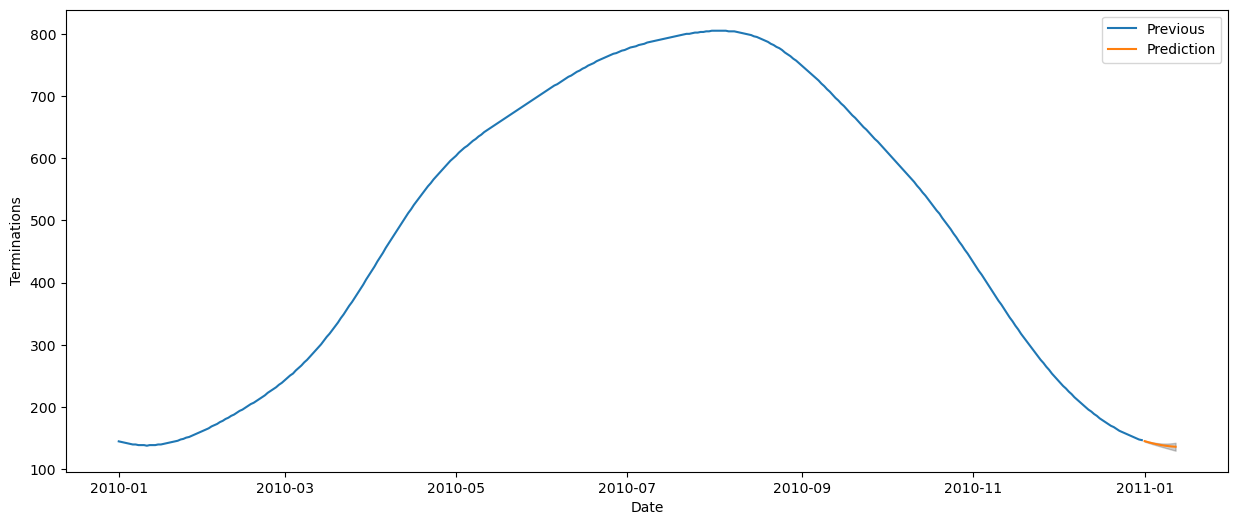

In [27]:
#plot the predictions for validation set
plt.plot(df.iloc[:,0], label='Previous')
plt.plot(preds.Prediction, label='Prediction')

plt.fill_between(preds.index,preds.Lower,preds.Upper,color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel('Terminations')
plt.legend(loc='best')
plt.show()